## <u>*Calssifications Modelling for vehicle age as a Target Feature*</u>

In [ ]:
%run  C:\Users\Omar\Desktop\Omar_Files\Python_Analysis\Auto_Insurance\Notebooks\Data_Analysis\3_EDA.ipynb

In [15]:
df5=df.copy()
df5.drop(["clm"],axis=1,inplace=True)

In [17]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import matplotlib
matplotlib.rcParams["figure.figsize"]=(20,10)
import seaborn as sns;sns.set()
import warnings
warnings.filterwarnings('ignore')
import plotly.express as px
from datetime import datetime,time
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder,LabelEncoder,StandardScaler
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import (
    r2_score,accuracy_score,roc_auc_score,auc,roc_curve,precision_score,
    recall_score,precision_recall_curve,r2_score,classification_report,RocCurveDisplay,
    confusion_matrix,f1_score,ConfusionMatrixDisplay
    )


from sklearn.tree import DecisionTreeClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier
import warnings
from sklearn.ensemble import (
    AdaBoostClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier,BaggingClassifier
)

from hyperopt import fmin,tpe,STATUS_OK,Trials,hp
from sklearn.utils.multiclass import unique_labels
import plotclassification ,plotly
# import matplotlib.pyplot as plt
from yellowbrick.classifier import ClassificationReport
   

### *A.*<br> <u>*Models Preparation :*</u>

#### *A.1. <br> <u>Classification Models to use :*</u>

In [18]:
models = {
                "RandomForestClassifier": RandomForestClassifier(),
                "DecisionTreeClassifier": DecisionTreeClassifier(),
                "GradientBoostingClassifier": GradientBoostingClassifier(),
                "XGBClassifier": XGBClassifier(),
                "CatBoostClassifier": CatBoostClassifier(verbose=False),
                "AdaBoostClassifier": AdaBoostClassifier(),
                "BaggingClassifier":BaggingClassifier()
            }

#### *A.2. <br> <u>Classification Models spaces preperartion to use in hyperopt :*</u>

In [19]:
space_xgboost_clf  = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_child_weight': hp.quniform('min_child_weight', 1, 10, 1),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
    'gamma': hp.uniform('gamma', 0, 1),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.5, 1.0),
}

space_rf_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
    'bootstrap': hp.choice('bootstrap', [True, False]),
}


space_GradientBoosting_clf = {
    'n_estimators': hp.quniform('n_estimators', 50, 200, 1),
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'max_depth': hp.choice('max_depth', range(3, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    'subsample': hp.uniform('subsample', 0.5, 1.0),
}

space_DT = {
    #'criterion': hp.choice('criterion', ['gini', 'entropy']),
    'splitter': hp.choice('splitter', ['best', 'random']),
    'max_depth': hp.choice('depth', range(1, 15)),
    'min_samples_split': hp.uniform('min_samples_split', 0.1, 1.0),
    'min_samples_leaf': hp.uniform('min_samples_leaf', 0.1, 0.5),
    #'max_features': hp.choice('max_features', ['auto', 'sqrt', 'log2', None]),
}



space_Bagging_clf = {
    'n_estimators': hp.quniform('n_estimators', 10, 200, 1),
    'max_samples': hp.uniform('max_samples', 0.1, 1.0),
    'max_features': hp.uniform('max_features', 0.1, 1.0),
    'bootstrap': hp.choice('bootstrap', [True, False]),
    'bootstrap_features': hp.choice('bootstrap_features', [True, False]),
}

space_catboost_clf = {
    'learning_rate': hp.loguniform('learning_rate', -5, 0),
    'iterations': hp.quniform('iterations', 50, 200, 1),
    'depth': hp.choice('depth', range(1, 15)),
    'l2_leaf_reg': hp.uniform('l2_leaf_reg', 0.1, 10),
    'border_count': hp.choice('border_count', [32, 64, 128, 256]),
    'bagging_temperature': hp.uniform('bagging_temperature', 0, 1),
    'random_strength': hp.uniform('random_strength', 0, 1),
}

---

### *B. <br> <u>Data preparation:*</u>

#### *B.1. <br> <u>Solving imbalanced issue if exist :*</u>

In [20]:
print(df5.groupby("veh_age")["veh_age"].count())
print(df5.groupby("veh_age")["veh_age"].count()/df5["veh_age"].count())

veh_age
1    12257
2    16587
3    20064
4    18948
Name: veh_age, dtype: int64
veh_age
1    0.180633
2    0.244444
3    0.295685
4    0.279238
Name: veh_age, dtype: float64


> *The data balnance between between veh_age are acceptable*

#### *B.2. <br> <u>LabelEncoding for categorical features :*</u>

In [21]:
LabelEncoder_cat = LabelEncoder()
for col in df5:
    if col in ["numclaims","veh_body","veh_age","gender","area","agecat"]:
        df5[col]=LabelEncoder_cat.fit_transform(df5[col])

#### *B.3. <br> <u>Define x & y features :*</u>

In [22]:
x=df5.drop("veh_age",axis=1)
y=df5["veh_age"]

#### *B.5. <br> <u>data splitting (training & testing) :*</u>

In [23]:
xtrain,xtest, ytrain, ytest = train_test_split(x, y, train_size=0.7, test_size=0.3,random_state=41)

---

### *C. <br> <u>Modelling:*</u>

* *Note : Data scalling is not required as we are applying Tree -based models*

#### *C.1 <br> <u>* *XGBClassifier:*</u>

In [24]:
def model_XGBClassifier(space_xgboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(space_xgboost_clf['learning_rate']),
               n_estimators=int(space_xgboost_clf['n_estimators']),
               max_depth=int(space_xgboost_clf['max_depth']),
               min_child_weight=int(space_xgboost_clf['min_child_weight']),
               subsample=float(space_xgboost_clf["subsample"]),
               gamma=float(space_xgboost_clf['gamma']),
               colsample_bytree=float(space_xgboost_clf['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [25]:
def model_XGBClassifier_best(best_model_XGBClassifier):
    y_model_XGBClassifier_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
           #('preprocessor', preprocessor),
            ("XGBClassifier",XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])                                      

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_XGBClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_XGBClassifier_best Accuracy_result:',  np.mean(Accuracy_list))

In [26]:
best_model_XGBClassifier = fmin(fn=model_XGBClassifier, space=space_xgboost_clf, algo=tpe.suggest, max_evals=10)


100%|██████████| 10/10 [00:55<00:00,  5.56s/trial, best loss: 0.6091762047452964]


In [27]:
model_XGBClassifier_best(best_model_XGBClassifier)

model_XGBClassifier_best Accuracy_result: 0.7236822714545366


---

#### *C.2 <br> <u>* *RandomForestClassifier:*</u>

In [23]:
def model_rf_clf(space_rf_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(space_rf_clf['n_estimators']),
                                    #criterion=int(space_rf_clf['criterion']),                                                       
                                    max_depth=int(space_rf_clf['max_depth']),
                                    min_samples_split=float(space_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(space_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(space_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [24]:
def model_rf_clf_best(best_model_rf_clf):
    y_model_rf_clf_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
              ("RandomForestClassifier",RandomForestClassifier(              
                                    n_estimators=int(best_model_rf_clf['n_estimators']),
                                    #criterion=int(best_model_rf_clf['criterion']),                                                       
                                    max_depth=int(best_model_rf_clf['max_depth']),
                                    min_samples_split=float(best_model_rf_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_rf_clf['min_samples_leaf']),
                                    #max_features=float(space_rf_clf["max_features"]),
                                    bootstrap=int(best_model_rf_clf['bootstrap'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_model_rf_clf_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_rf_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [25]:
best_model_rf_clf = fmin(fn=model_rf_clf, space=space_rf_clf, algo=tpe.suggest, max_evals=10)
model_rf_clf_best(best_model_rf_clf)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]

100%|██████████| 10/10 [00:09<00:00,  1.04trial/s, best loss: 0.29714594488382373]
model_rf_clf_best Accuracy_result: 0.3752026330009333


---

#### *C.3 <br> <u>* *GradientBoostingClassifier:*</u>

In [20]:
def model_GradientBoosting_clf(space_GradientBoosting_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(space_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(space_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(space_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(space_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(space_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(space_GradientBoosting_clf['subsample'])

                                    ))

                                    ])
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [21]:
def model_GradientBoosting_clf_best(best_model_GradientBoosting_clf):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("GradientBoostingClassifier",GradientBoostingClassifier(              
                                    n_estimators=int(best_model_GradientBoosting_clf['n_estimators']),                                                       
                                    learning_rate=float(best_model_GradientBoosting_clf['learning_rate']),
                                    max_depth=int(best_model_GradientBoosting_clf['max_depth']),
                                    min_samples_split=float(best_model_GradientBoosting_clf['min_samples_split']),
                                    min_samples_leaf=float(best_model_GradientBoosting_clf['min_samples_leaf']),
                                    subsample=float(best_model_GradientBoosting_clf['subsample'])


                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_GradientBoosting_clf_best Accuracy_result:',  np.mean(Accuracy_list))

In [22]:
best_model_GradientBoosting_clf = fmin(fn=model_GradientBoosting_clf, space=space_GradientBoosting_clf, algo=tpe.suggest, max_evals=10)
model_GradientBoosting_clf_best(best_model_GradientBoosting_clf)

100%|██████████| 10/10 [01:37<00:00,  9.71s/trial, best loss: 0.29714594488382373]
model_GradientBoosting_clf_best Accuracy_result: 0.29714594488382373


----

#### *C.4 <br> <u>* *DecisionTreeClassifier:*</u>

In [15]:
def model_DT(space_DT):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(space_DT['criterion']),                                                       
                                    splitter=str(space_DT['splitter']),
                                    max_depth=int(space_DT['max_depth']),
                                    min_samples_split=float(space_DT['min_samples_split']),
                                    min_samples_leaf=float(space_DT['min_samples_leaf']),
                                    #max_features=int(space_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 


In [18]:
def model_DT_best(best_model_DT):
    y_DT_best=[]
    Accuracy_list=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",DecisionTreeClassifier(              
                                    #criterion=int(best_model_DT['criterion']),                                                       
                                    #splitter=str(best_model_DT['splitter']),
                                    max_depth=int(best_model_DT['depth']),
                                    min_samples_split=float(best_model_DT['min_samples_split']),
                                    min_samples_leaf=float(best_model_DT['min_samples_leaf']),
                                    #max_features=int(best_model_DT['max_features'])

                                    ))

                                    ])

                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_DT_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_DT_best Accuracy_result:',  np.mean(Accuracy_list))

In [19]:
best_model_DT = fmin(fn=model_DT, space=space_DT, algo=tpe.suggest, max_evals=10)
model_DT_best(best_model_DT)

100%|██████████| 10/10 [00:00<00:00, 54.65trial/s, best loss: 0.29714594488382373]
model_DT_best Accuracy_result: 0.4187748685955691


---

#### *C.5 <br> <u>* *BaggingClassifier:*</u>

In [12]:
def model_Bagging(space_Bagging_clf):
    base_classifier =DecisionTreeClassifier()
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("BaggingClassifier",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(space_Bagging_clf['n_estimators']),
                                    bootstrap=int(space_Bagging_clf["bootstrap"]),                                                       
                                    bootstrap_features=int(space_Bagging_clf['bootstrap_features']),
                                    max_samples=float(space_Bagging_clf["max_samples"]),
                                    max_features=float(space_Bagging_clf["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [13]:
def model_Bagging_best(best_model_BaggingClassifier):
    base_classifier =DecisionTreeClassifier()
    y_Bagging_best=[]
    Accuracy_list=[]

    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",BaggingClassifier(base_estimator=base_classifier,                
                                    n_estimators=int(best_model_BaggingClassifier['n_estimators']),
                                    bootstrap=int(best_model_BaggingClassifier["bootstrap"]),                                                       
                                    bootstrap_features=int(best_model_BaggingClassifier['bootstrap_features']),
                                    max_samples=float(best_model_BaggingClassifier["max_samples"]),
                                    max_features=float(best_model_BaggingClassifier["max_features"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_Bagging_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    Accuracy_list.append(Accuracy_result)
   

    print('model_Bagging_best Accuracy_result:',  np.mean(Accuracy_list))

In [14]:
best_model_BaggingClassifier=fmin(fn=model_Bagging, space=space_Bagging_clf, algo=tpe.suggest, max_evals=10)
model_Bagging_best(best_model_BaggingClassifier)

100%|██████████| 10/10 [01:07<00:00,  6.80s/trial, best loss: 0.46234710419020486]
model_Bagging_best Accuracy_result: 0.5267475561232009


---

#### *C.6 <br> <u>* *CatBoostClassifier:*</u>

In [29]:
def model_catboost(space_catboost_clf):
    accuracyList=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(space_catboost_clf['learning_rate']),
                                    depth=int(space_catboost_clf["depth"]),                                                       
                                    iterations=int(space_catboost_clf['iterations']),
                                    l2_leaf_reg=float(space_catboost_clf["l2_leaf_reg"]),
                                    border_count=int(space_catboost_clf["border_count"]),
                                    bagging_temperature=float(space_catboost_clf["bagging_temperature"]),
                                    random_strength=float(space_catboost_clf["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    Accuracy_result=accuracy_score(ytest,model_opt.predict(xtest))
    accuracyList.append(Accuracy_result)                         
    mean_Accuracy_result=np.mean(accuracyList)                          
    return { 
           'loss': mean_Accuracy_result,
           'status': STATUS_OK
            } 

In [30]:
def model_catboost_best(best_model_catboost):
    y_CatBoostClassifier_best=[]
    model_opt = Pipeline(
        steps=[
            #('preprocessor', preprocessor),
            ("CatBoostRegressor",CatBoostClassifier(
                                    learning_rate=float(best_model_catboost['learning_rate']),
                                    depth=int(best_model_catboost["depth"]),                                                       
                                    iterations=int(best_model_catboost['iterations']),
                                    l2_leaf_reg=float(best_model_catboost["l2_leaf_reg"]),
                                    border_count=int(best_model_catboost["border_count"]),
                                    bagging_temperature=float(best_model_catboost["bagging_temperature"]),
                                    random_strength=float(best_model_catboost["random_strength"])

                                    ))

                                    ])
                                              
                                  
    model_opt.fit(xtrain,ytrain)
    y_pred=model_opt.predict(xtest)
    y_CatBoostClassifier_best.append(y_pred)

    Accuracy_result=accuracy_score(ytest,y_pred)
    print('model_catboost_best Accuracy_result:', Accuracy_result)


In [31]:
best_model_catboost = fmin(fn=model_catboost, space=space_catboost_clf, algo=tpe.suggest, max_evals=10)
model_catboost_best(best_model_catboost)

  0%|          | 0/10 [00:00<?, ?trial/s, best loss=?]0:	learn: 1.3677055	total: 150ms	remaining: 9s
1:	learn: 1.3518115	total: 163ms	remaining: 4.79s
2:	learn: 1.3358038	total: 173ms	remaining: 3.34s
3:	learn: 1.3212891	total: 182ms	remaining: 2.6s
4:	learn: 1.3092564	total: 191ms	remaining: 2.14s
5:	learn: 1.2986899	total: 201ms	remaining: 1.84s
6:	learn: 1.2866156	total: 210ms	remaining: 1.62s
7:	learn: 1.2755492	total: 223ms	remaining: 1.47s
8:	learn: 1.2672090	total: 232ms	remaining: 1.34s
9:	learn: 1.2572369	total: 242ms	remaining: 1.23s
10:	learn: 1.2496787	total: 252ms	remaining: 1.15s
11:	learn: 1.2431120	total: 260ms	remaining: 1.06s
12:	learn: 1.2344855	total: 270ms	remaining: 996ms
13:	learn: 1.2265370	total: 278ms	remaining: 934ms
14:	learn: 1.2210490	total: 287ms	remaining: 882ms
15:	learn: 1.2137695	total: 295ms	remaining: 830ms
16:	learn: 1.2089527	total: 304ms	remaining: 786ms
17:	learn: 1.2025967	total: 311ms	remaining: 743ms
18:	learn: 1.1983136	total: 319ms	remainin

---

### *D <br> <u>* *running Results:*</u>

### *D.1 <br> <u>* *best Results:*</u>

> *XGBClassifier has the highest accuracy score*

In [28]:
y_Bagging_best=[]
Accuracy_list=[]

XGBClassifier_model = XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree']))

                                                                               
XGBClassifier_model.fit(xtrain,ytrain)
Accuracy_result=accuracy_score(ytest,XGBClassifier_model.predict(xtest))
y_pred=XGBClassifier_model.predict(xtest)
y_Bagging_best.append(y_pred)

Accuracy_result=accuracy_score(ytest,y_pred)
Accuracy_list.append(Accuracy_result)
    

In [29]:
print(classification_report(ytest,y_pred))

              precision    recall  f1-score   support

           0       0.70      0.64      0.67      3672
           1       0.63      0.66      0.65      4975
           2       0.69      0.73      0.71      6049
           3       0.87      0.83      0.85      5661

    accuracy                           0.72     20357
   macro avg       0.72      0.71      0.72     20357
weighted avg       0.73      0.72      0.72     20357



In [30]:
unique_labels(ytest)
labels=unique_labels(ytest)
col_names=[f"predicted{label}"for label in labels ]
index_names=[f"Actual{label}"for label in labels ]
pd.DataFrame(confusion_matrix(ytest, y_pred),columns=col_names,index=index_names)

,predicted0,predicted1,predicted2,predicted3
Actual0,2339,1027,288,18
Actual1,725,3293,885,72
Actual2,241,791,4387,630
Actual3,32,94,822,4713


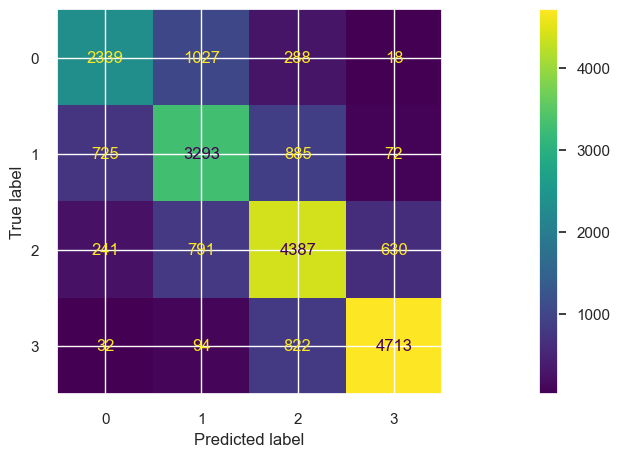

In [31]:
matplotlib.rcParams["figure.figsize"]=(25,5)
ConfusionMatrixDisplay(confusion_matrix(ytest,y_pred)).plot()

In [32]:
from sklearn.multiclass import OneVsRestClassifier

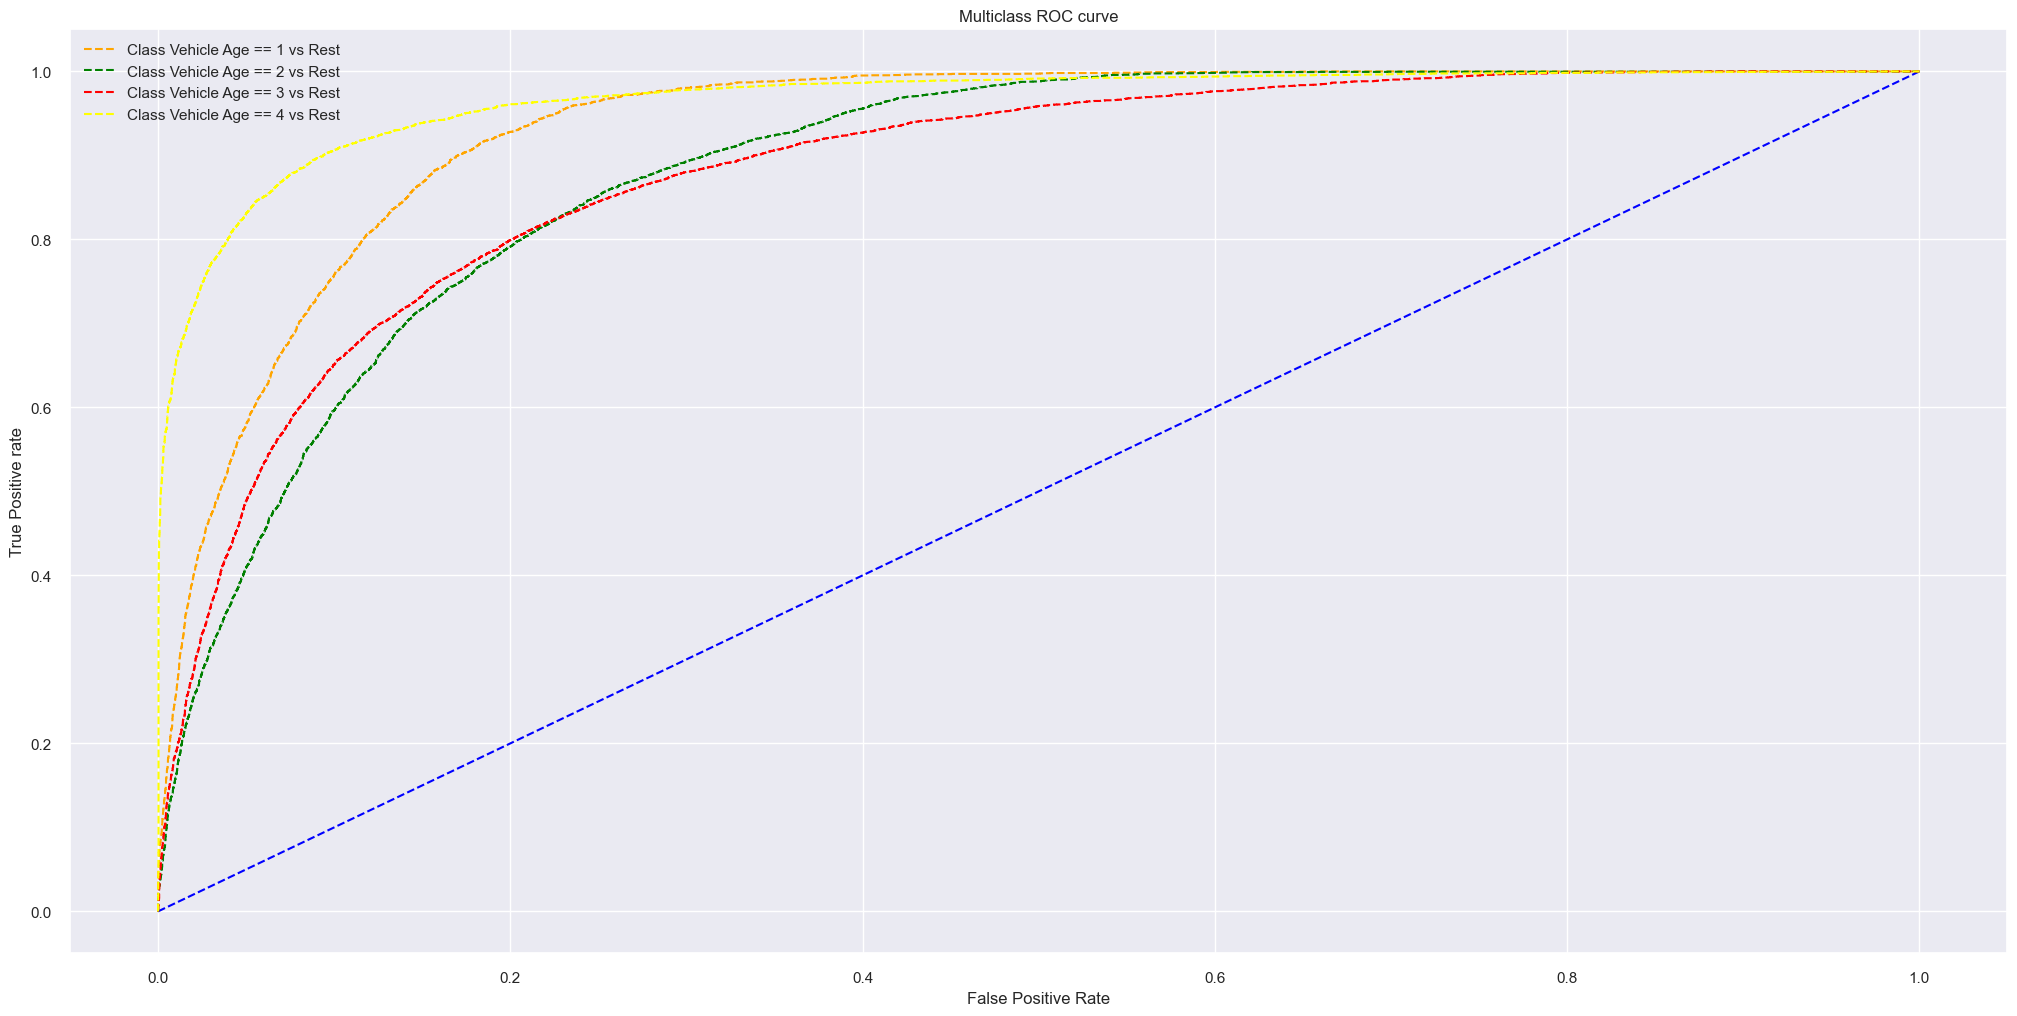

In [33]:
matplotlib.rcParams["figure.figsize"]=(25,12)
clf = OneVsRestClassifier(XGBClassifier( 
               learning_rate=float(best_model_XGBClassifier['learning_rate']),
               n_estimators=int(best_model_XGBClassifier['n_estimators']),
               max_depth=int(best_model_XGBClassifier['max_depth']),
               min_child_weight=int(best_model_XGBClassifier['min_child_weight']),
               subsample=float(best_model_XGBClassifier["subsample"]),
               gamma=float(best_model_XGBClassifier['gamma']),
               colsample_bytree=float(best_model_XGBClassifier['colsample_bytree'])))
                           

clf.fit(xtrain, ytrain)
pred = clf.predict(xtest)
pred_prob = clf.predict_proba(xtest)

# roc curve for classes
fpr = {}
tpr = {}
thresh ={}

n_class = 4

random_probs = [0 for i in range(len(ytest))]
p_fpr, p_tpr, _ = roc_curve(ytest, random_probs, pos_label=1)
for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(ytest, pred_prob[:,i], pos_label=i)
    
# plotting    
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange', label='Class Vehicle Age == 1 vs Rest')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green', label='Class Vehicle Age == 2 vs Rest')
plt.plot(fpr[2], tpr[2], linestyle='--',color='red', label='Class Vehicle Age == 3 vs Rest')
plt.plot(fpr[3], tpr[3], linestyle='--',color='yellow', label='Class Vehicle Age == 4 vs Rest')

plt.title('Multiclass ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive rate')
plt.legend(loc='best')
#plt.savefig('Multiclass ROC',dpi=300);    


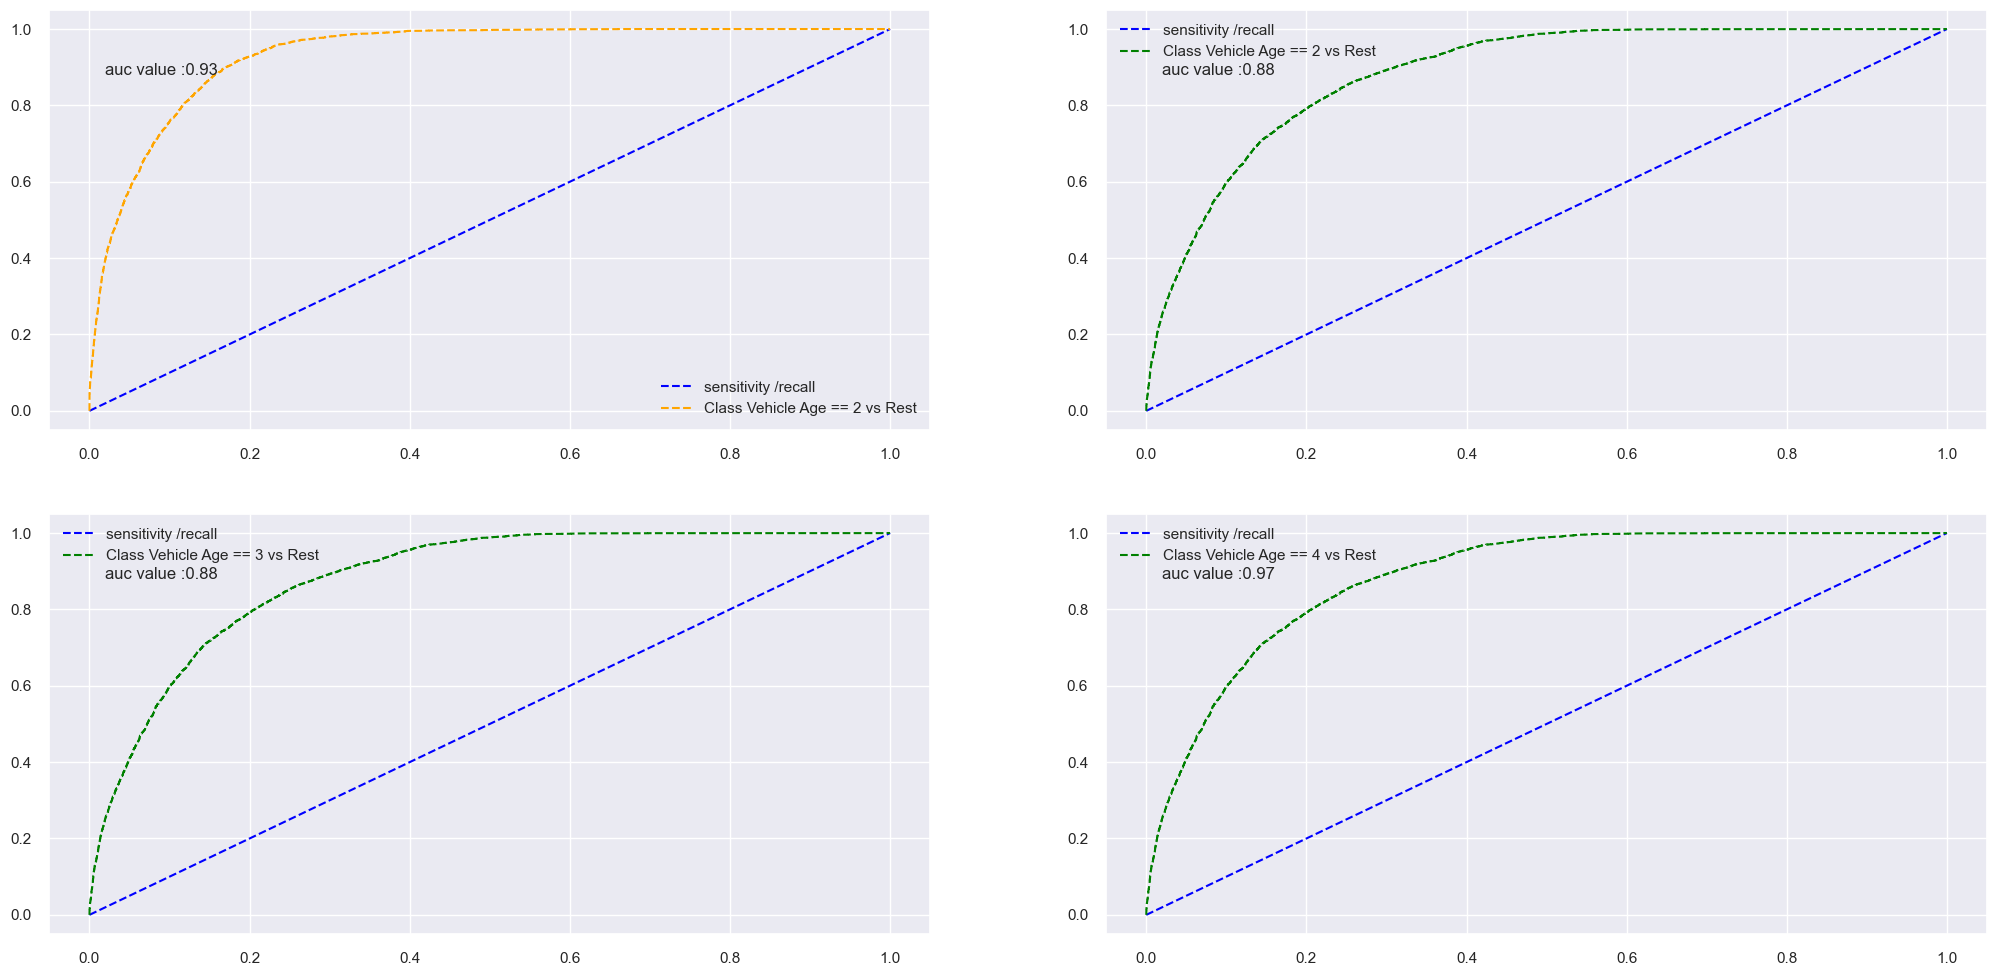

In [34]:
plt.subplot(221)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[0], tpr[0], linestyle='--',color='orange')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[0], tpr[0]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 2 vs Rest'])

plt.subplot(222)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[1], tpr[1]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 2 vs Rest'])

plt.subplot(223)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[2], tpr[2]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 3 vs Rest'])

plt.subplot(224)
plt.plot(p_fpr, p_tpr, linestyle='--', color='blue')
plt.plot(fpr[1], tpr[1], linestyle='--',color='green')
plt.text(0.02,0.88, f'auc value :{round(auc(fpr[3], tpr[3]),2)}')
plt.legend(['sensitivity /recall','Class Vehicle Age == 4 vs Rest'])

---

* *Features Importance*

In [35]:
importance=pd.concat([pd.DataFrame(XGBClassifier_model.feature_names_in_,columns=["feature_names"]),
           pd.DataFrame(XGBClassifier_model.feature_importances_,columns=["feature_importances"])],axis=1)

In [36]:
Veh_ageImportanceTabel=importance.sort_values(by='feature_importances',ascending=False)
Veh_ageImportanceTabel.to_pickle("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Table/Veh_ageImportanceTabel.pkl")

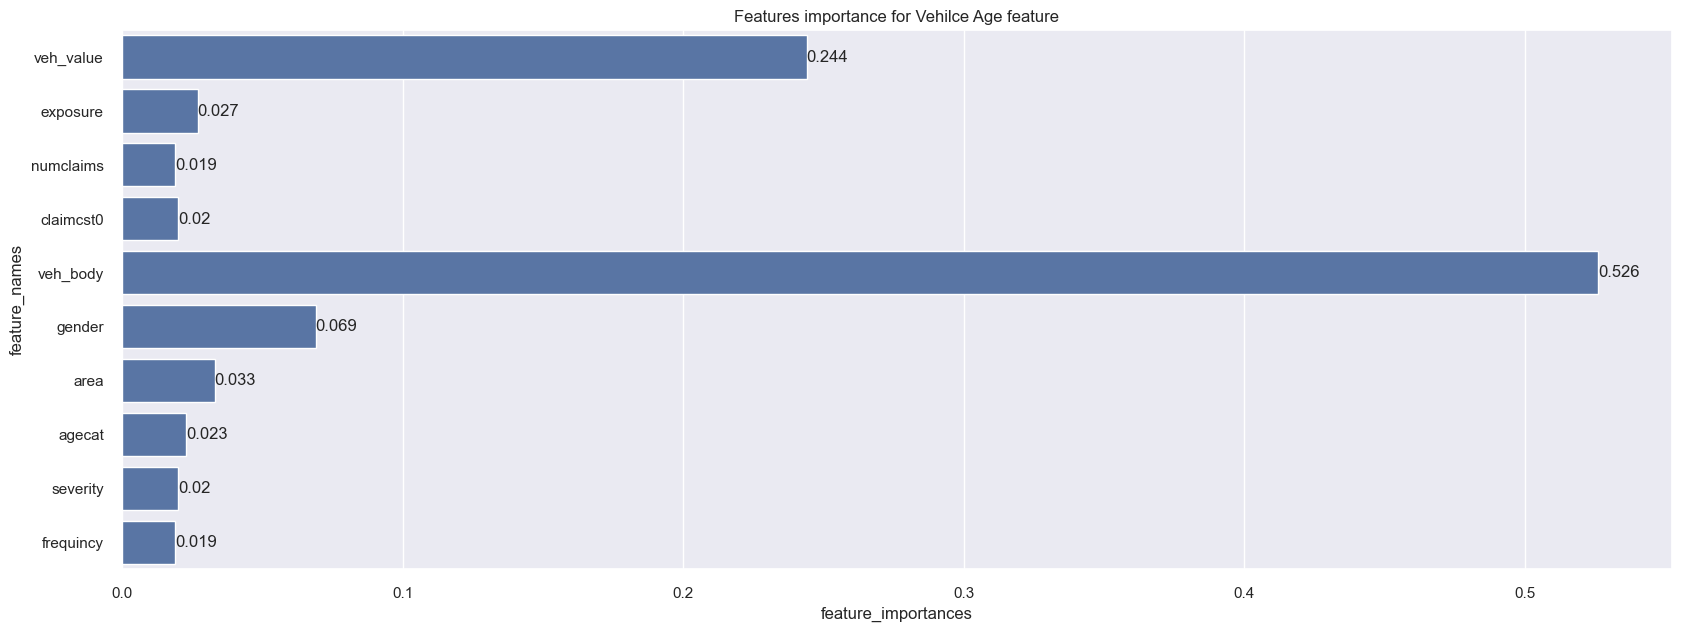

In [37]:
matplotlib.rcParams["figure.figsize"]=(20,7)
ax=sns.barplot(x=np.round(importance["feature_importances"],3),y=importance["feature_names"])
plt.title('Features importance for Vehilce Age feature')
ax.bar_label(ax.containers[0]);
plt.savefig('C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/App/Feature_importance_Graph/Veh_age_featureImportanc',dpi=500); 

In [38]:
import pickle
with open ("C:/Users/Omar/Desktop/Omar_Files/Python_Analysis/Auto_Insurance/final_models/vehage_prediction_model.pkl","wb") as f:
    pickle.dump(XGBClassifier_model,f)

---